In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

In [2]:
from tqdm import tqdm
import requests
import os
import zipfile

def download_file(src_url, dst_fn):
    
    if os.path.exists(dst_fn):
        print('File %s already exists' % dst_fn)
        return
    
    print('Downloading %s' % dst_fn)
    
    # Streaming, so we can iterate over the response.
    r = requests.get(src_url, stream=True)

    # Total size in MB.
    total_size = int(r.headers.get('content-length', 0)); 
    block_size = 1024
    wrote = 0 
    with open(dst_fn, 'wb') as f:
        with tqdm(total=total_size//block_size, unit='kB', 
                           unit_scale=True, unit_divisor=1024) as pbar:
            for data in r.iter_content(block_size):
                wrote = wrote + len(data)
                pbar.update(1)
                f.write(data)
    if total_size != 0 and wrote != total_size:
        print("ERROR, something went wrong") 

# Get file names
matlab_dir = 'matlab'
digits_fn =  os.path.join(matlab_dir,'emnist-digits.mat')
letters_fn = os.path.join(matlab_dir,'emnist-letters.mat')

# Check if files exists
if os.path.exists(matlab_dir):
    if os.path.exists(digits_fn) and os.path.exists(letters_fn):
        print('Files already downloaded')
        files_exists = True
else:
    files_exists = False
    
if not files_exists:
    # First download the zip file if needed
    src_url = "http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip"
    dst_fn = 'matlab.zip'
    download_file(src_url, dst_fn)
    
    # Then, unzip the file
    print('Unzipping %s...' % dst_fn)
    zip_ref = zipfile.ZipFile(dst_fn, 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    print('Unzip completed')

Files already downloaded


In [3]:
import scipy.io
def load_emnist(file_path='emnist-digits.mat'):
    """
    Loads training and test data with ntr and nts training and test samples
    The `file_path` is the location of the `eminst-balanced.mat`.
    """    
    
    # Load the MATLAB file
    mat = scipy.io.loadmat(file_path)
    
    # Get the training data
    Xtr = mat['dataset'][0][0][0][0][0][0][:]
    ntr = Xtr.shape[0]
    ytr = mat['dataset'][0][0][0][0][0][1][:].reshape(ntr).astype(int)
    
    # Get the test data
    Xts = mat['dataset'][0][0][1][0][0][0][:]
    nts = Xts.shape[0]
    yts = mat['dataset'][0][0][1][0][0][1][:].reshape(nts).astype(int)
    
    print("%d training samples, %d test samples loaded" % (ntr, nts))

    return [Xtr, Xts, ytr, yts]

In [4]:
# TODO 1:  Load the digit data from emnist-digits.mat

Xtr_dig, Xts_dig, ytr_dig, yts_dig = load_emnist(digits_fn)

240000 training samples, 40000 test samples loaded


In [5]:
# TODO 2:  Load the digit data from emnist-letters.mat
Xtr_let, Xts_let, ytr_let, yts_let = load_emnist(letters_fn)

124800 training samples, 20800 test samples loaded


In [6]:
def plt_digit(x,y=None):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq.T,  cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])    
    if y != None:
        plt.title('%d' % y)  

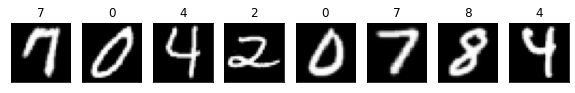

In [7]:
# TODO 3:  Plot 8 random samples from the training data of the digits
nplt = 8
ntr = Xtr_dig.shape[0]
Iperm = np.random.permutation(ntr)
plt.figure(figsize=(10,20))
for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(1,nplt,i+1)
    plt_digit(Xtr_dig[ind,:],ytr_dig[ind])

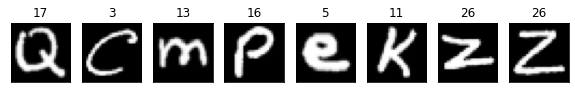

In [8]:
# TODO 4:  Plot 8 random samples from the training data of the letters
ntr_l = Xtr_let.shape[0]
Iperm_l = np.random.permutation(ntr_l)
plt.figure(figsize=(10,20))
for i in range(nplt):
    ind = Iperm_l[i]
    plt.subplot(1,nplt,i+1)
    plt_digit(Xtr_let[ind,:],ytr_let[ind])

In [9]:
remove_list = np.array([9,12,15])

# TODO 5:  Create arrays with labels 9, 12 and 15 removed
I = np.all(ytr_let[:,None] != remove_list[None,:], axis=1) 
Xtr_let_rem = Xtr_let[I,:]
ytr_let_rem = ytr_let[I]
I = np.all(yts_let[:,None] != remove_list[None,:], axis=1) 
Xts_let_rem = Xts_let[I,:]
yts_let_rem = yts_let[I]

In [10]:
# Number of training and test digits and letters
ntr_dig = 5000
ntr_let = 1000
nts_dig = 5000
nts_let = 1000

# TODO 6 Create sub-sampled training and test data
def random_select(x,y,nsamp):
  n = x.shape[0]
  I = np.random.permutation(n)
  x_res = x[I[:nsamp],:]
  y_res = y[I[:nsamp]]
  return x_res, y_res
Xtr1_dig, ytr1_dig = random_select(Xtr_dig,ytr_dig,ntr_dig)
Xts1_dig, yts1_dig = random_select(Xts_dig,yts_dig,nts_dig)
Xtr1_let, ytr1_let = random_select(Xtr_let_rem,ytr_let_rem,ntr_let)
Xts1_let, yts1_let = random_select(Xts_let_rem,yts_let_rem,nts_let)

In [11]:
# TODO 7:  Create combined letter and digit training and test data
Xtr = np.vstack((Xtr1_dig,Xtr1_let))
ytr = np.hstack((ytr1_dig, np.ones(ntr_let,dtype='int')*10))
Xts = np.vstack((Xts1_dig,Xts1_let))
yts = np.hstack((yts1_dig, np.ones(nts_let,dtype='int')*10))

In [12]:
# TODO 8:  Rescale the data from -1 to 1
Xtr1 = (Xtr*2)/float(255) - 1
Xts1 = (Xts*2)/float(255) - 1

In [13]:
from sklearn import svm
# TODO 9:  Create a classifier: a support vector classifier
svc = svm.SVC(probability=False,  kernel="rbf", C=2.8, gamma=.0073,verbose=10)

In [14]:
# TODO 10:  Fit the classifier on the training data. 
svc.fit(Xtr1,ytr)

[LibSVM]

SVC(C=2.8, gamma=0.0073, verbose=10)

In [15]:
# TODO 11:  Measure error on the test data
yhat_ts = svc.predict(Xts1)
acc = np.mean(yhat_ts == yts)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.893333


In [16]:
# TODO 12:  Print a confusion matrix
from sklearn.metrics import confusion_matrix
C = confusion_matrix(yts,yhat_ts)
Csum = np.sum(C,1)
C = C / Csum[None,:]
print(C)

[[0.94178794 0.00211864 0.         0.         0.00190476 0.
  0.0019084  0.         0.         0.         0.025     ]
 [0.         0.95762712 0.00401606 0.00189036 0.         0.
  0.         0.         0.00208333 0.         0.016     ]
 [0.002079   0.00211864 0.91767068 0.00189036 0.00190476 0.002
  0.         0.00574713 0.00625    0.         0.03      ]
 [0.002079   0.00423729 0.01807229 0.93194707 0.         0.01
  0.         0.00191571 0.01041667 0.00426439 0.011     ]
 [0.         0.00211864 0.         0.         0.92380952 0.
  0.         0.         0.         0.01066098 0.034     ]
 [0.01039501 0.00211864 0.00200803 0.02646503 0.         0.888
  0.00572519 0.00383142 0.00416667 0.0021322  0.027     ]
 [0.         0.         0.00200803 0.         0.00190476 0.002
  0.95801527 0.         0.00208333 0.         0.018     ]
 [0.         0.00635593 0.         0.         0.00761905 0.
  0.         0.94444444 0.         0.02558635 0.01      ]
 [0.         0.00211864 0.00401606 0.00756144

In [17]:
# TODO 13:  Print above two error rates
f1 = np.mean((yhat_ts == 10) & (yts < 10))
f2 = np.mean((yhat_ts < 10) & (yts == 10))
print('Fraction of digits are mislabeled as letters = {}'.format(f1))
print('Fraction of letters are mislabeled as digits = {}'.format(f2))

Fraction of digits are mislabeled as letters = 0.039
Fraction of letters are mislabeled as digits = 0.043666666666666666


In [18]:
C_test = [0.1,1,10]
gam_test = [0.001,0.01,0.1]

nC = len(C_test)
ngam = len(gam_test)
acc = np.zeros((nC,ngam))

# TODO 14:  Measure and print the accuracy for each C and gamma value.  Store the results in acc
for i,c in enumerate(C_test):
  for j,gam in enumerate(gam_test):
    svc = svm.SVC(probability=False,  kernel="rbf", C=c, gamma=gam,verbose=10)
    svc.fit(Xtr1,ytr)
    yhat = svc.predict(Xts1)
    acc[i,j] = np.mean(yhat == yts)
    print('C = {}, gamma = {}, Accuracy = {}'.format(c,gam,acc[i,j]))

# TODO 15:  Print the accuracy matrix
print(acc)
# TODO 16:  Print the maximum accuracy and the corresponding best C and gamma
imax = np.argmax(acc)
i, j = np.unravel_index(imax, (nC,ngam))
acc_max = np.max(acc)
print('Optimal C = {}, gamma = {}, Accuracy = {}'.format(C_test[i],gam_test[j],acc_max))

[LibSVM]C = 0.1, gamma = 0.001, Accuracy = 0.51
[LibSVM]C = 0.1, gamma = 0.01, Accuracy = 0.803
[LibSVM]C = 0.1, gamma = 0.1, Accuracy = 0.22233333333333333
[LibSVM]C = 1, gamma = 0.001, Accuracy = 0.805
[LibSVM]C = 1, gamma = 0.01, Accuracy = 0.8843333333333333
[LibSVM]C = 1, gamma = 0.1, Accuracy = 0.3855
[LibSVM]C = 10, gamma = 0.001, Accuracy = 0.845
[LibSVM]C = 10, gamma = 0.01, Accuracy = 0.9001666666666667
[LibSVM]C = 10, gamma = 0.1, Accuracy = 0.43133333333333335
[[0.51       0.803      0.22233333]
 [0.805      0.88433333 0.3855    ]
 [0.845      0.90016667 0.43133333]]
Optimal C = 10, gamma = 0.01, Accuracy = 0.9001666666666667
